### Things to do
#### General Notes
- `airline_sentiment` and possibly `airline_sentiment_confidence` are target columns (the latter cannot be in traning data)
- Remove instance of `"@airline"` tags from text 

####  How to handle each column
**Numerical Columns**
- `negativereason_confidence` -- fill missing data with 0
- `retweet_count` -- remove, almost 100% is just 0

**Categorical Columns**
- `negativereason` -- one hot encode top K reasons +1 column for "other"
- `airline` -- remove or one hot encode with "other" column
- `airline_sentiment_gold` -- remove, almost 100% missing data
- `name` -- remove, unique data
- `negative_reason_gold` -- remove, almost 100% missing data
- `tweet_location` -- remove or one hot encode with "other" column

**Other Columns**
- `tweet_coord` -- remove, almost 100% missing data
- `user_timezone` -- remove, a lot of missing and correlates with location
- `tweet_created` -- convert to columns: day of year (sin/cos), day of week, time of day (sin/cos)
- `text` -- sklearn.feature_extraction.text -> CountVectorizer (?)


In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from src.transformers import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jasie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jasie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jasie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
def load_data():
    df = pd.read_csv('../data/Tweets.csv')
    df = df.drop(columns=['tweet_id'])

    df_train, df_test = train_test_split(df, test_size=0.1, stratify=df[['airline_sentiment']], random_state=0)

    X_train = df_train.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_train = df_train[['airline_sentiment']]

    X_test = df_test.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_test = df_test[['airline_sentiment']]

    return X_train, y_train, X_test, y_test

In [4]:
X_train, y_train, X_test, y_test = load_data()

In [31]:
columns_to_drop = ['retweet_count', 'airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 'name', 'user_timezone', 'negativereason', 'negativereason_confidence']
columns_to_fill_zero = []
columns_to_fill_unknown = ['tweet_location']
columns_to_ohe = ['airline', 'tweet_location']

column_order_after_transform = \
    columns_to_fill_zero \
    + columns_to_fill_unknown \
    + ['airline', 'text', 'tweet_created']
column_idx = lambda c : column_order_after_transform.index(c)

preprocessor = Pipeline(steps=[
    ('drop', DropColumnTransformer(columns_to_drop)),
    ('fill_missing', 
        ColumnTransformer(
            transformers=[
                ('fill_zero', SimpleImputer(strategy='constant', fill_value=0), columns_to_fill_zero),
                ('fill_other', SimpleImputer(strategy='constant', fill_value='Unknown'), columns_to_fill_unknown),
                
            ], 
            remainder='passthrough')),
    ('encode', ColumnTransformer(transformers=[
        ('ohe', OneHotEncoder(
            handle_unknown='infrequent_if_exist', 
            max_categories=10, 
            sparse_output=False), 
            list(map(column_idx, columns_to_ohe))),
        ('time', TimeTransformer(), list(map(column_idx, ['tweet_created']))),
        ('text', TextTransformer(), list(map(column_idx, ['text'])))
    ],
    remainder='passthrough'))
])

In [32]:
X_train_processed = preprocessor.fit_transform(X_train)

In [33]:
X_train_processed.shape

(13176, 221)

In [34]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder

In [35]:
le = LabelEncoder()
y_train_processed = le.fit_transform(y_train)
y_test_processed = le.transform(y_test)

C:\Users\jasie\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jasie\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [36]:
clf = XGBClassifier(n_estimators=100)

In [ ]:
clf.fit(X_train_processed, y_train_processed)

In [38]:
y_train_pred = clf.predict(X_train_processed)

In [39]:
np.mean(y_train_pred == y_train_processed)

0.8363691560412871

In [40]:
X_test_processed = preprocessor.fit_transform(X_test)

In [41]:
y_test_pred = clf.predict(X_test_processed)

In [42]:
np.mean(y_test_pred == y_test_processed)

0.6379781420765027

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

<Axes: >

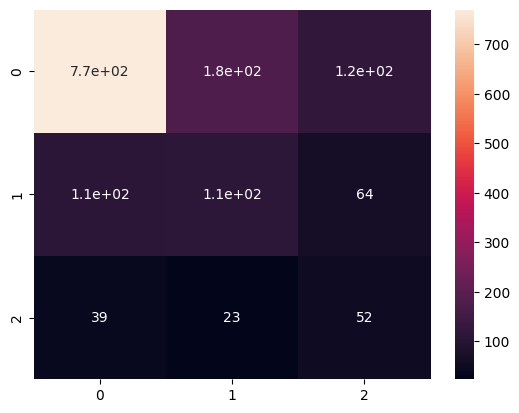

In [44]:
sns.heatmap(confusion_matrix(y_test_pred, y_test_processed), annot=True)